# About the POTS filter

What's the frequency and phase response?

In [1]:
%matplotlib inline
import json
import functools

import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
plt.style.use('ggplot')

FS = 44100

In [2]:
def combine_biquads(biquads):
    return [functools.reduce(sig.convolve, x) for x in zip(*biquads)]
    
with open('biquads.json') as f:
    biquadset = json.load(f)

filters = {f: combine_biquads(biquadset[f]) for f in biquadset}

In [3]:
SNR = 30

b, a = filters['signal']
w, h = sig.freqz(b, a, worN=4096)
freqs = FS * w / (2 * np.pi)
gain_sig = 20 * np.log10(np.abs(h))
phase_sig = np.unwrap(np.angle(h, deg=True))

b, a = filters['noiseband']
w, h = sig.freqz(b, a, worN=4096)
gain_noise = 20 * np.log10(np.abs(h)) - SNR
phase_noise = np.unwrap(np.angle(h, deg=True))

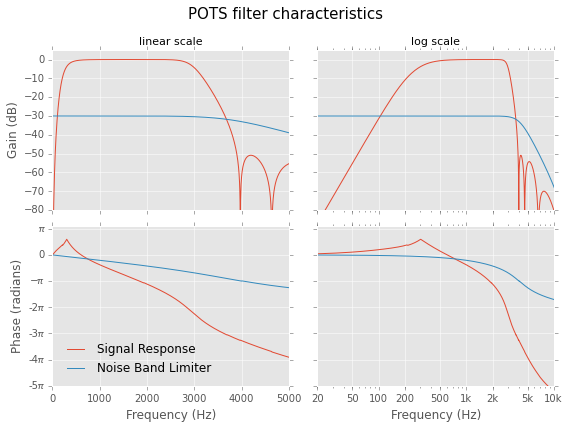

In [4]:
f = plt.figure(figsize=(8, 6))

ax_lin_gain = f.add_subplot(2, 2, 1)
ax_lin_phase = f.add_subplot(2, 2, 3, sharex=ax_lin_gain)
ax_log_gain = f.add_subplot(2, 2, 2, sharey=ax_lin_gain)
ax_log_phase = f.add_subplot(2, 2, 4, sharex=ax_log_gain, sharey=ax_lin_phase)

ax_lin_gain.set_xlim((0, 5000))
ax_log_gain.set_xlim((20, 10000))
ax_lin_gain.set_ylim((-80, 5))
ax_lin_phase.set_ylim((-800, 200))
ax_log_gain.set_xscale('log')
ax_log_phase.set_xscale('log')

plt.setp(ax_lin_gain.get_xticklabels(), visible=False)
plt.setp(ax_log_gain.get_xticklabels(), visible=False)
plt.setp(ax_log_gain.get_yticklabels(), visible=False)
plt.setp(ax_log_phase.get_yticklabels(), visible=False)

ax_lin_gain.plot(freqs, gain_sig)
ax_lin_gain.plot(freqs, gain_noise)
ax_log_gain.plot(freqs, gain_sig)
ax_log_gain.plot(freqs, gain_noise)
ax_lin_phase.plot(freqs, phase_sig, label="Signal Response")
ax_lin_phase.plot(freqs, phase_noise, label="Noise Band Limiter")
ax_log_phase.plot(freqs, phase_sig)
ax_log_phase.plot(freqs, phase_noise)

ax_lin_gain.set_ylabel('Gain (dB)')
ax_lin_phase.set_ylabel('Phase (radians)')
ax_lin_phase.set_xlabel('Frequency (Hz)')
ax_log_phase.set_xlabel('Frequency (Hz)')

logticks = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
ax_log_phase.set_xticks(logticks)
ax_log_phase.set_xticklabels([x if x < 1000 else '{:.0f}k'.format(x/1000) for x in logticks])

phaseticks = [180 * y for y in range(-5, 2)]
omegaticks = [{0: 0, 1: u'\u03C0', -1: u'\u2212\u03C0'}.get(y, '{}\u03C0'.format(y)) for y in range(-5, 2)]
ax_lin_phase.set_yticks(phaseticks)
ax_lin_phase.set_yticklabels(omegaticks)
ax_log_phase.set_yticks(phaseticks)

ax_lin_gain.set_title('linear scale', fontsize=11)
ax_log_gain.set_title('log scale', fontsize=11)
f.suptitle('POTS filter characteristics', fontsize=15)

ax_lin_phase.legend(loc='lower left')
ax_lin_phase.get_legend().get_frame().set_alpha(0)

f.tight_layout()
f.subplots_adjust(top=0.88)
f.savefig('pots-bodeplot.png')